# Simulation of galactic sources

In [1]:
import simulation ##This function draws sources from spatial distribution with luminosity 1-100GeV
import numpy as np
import makemap
import matplotlib as mpl
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.ticker

rc('font',**{'family':'serif'})
rc('text',usetex=True)
import pylab as plt
%matplotlib inline

/home/mart/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
##Setup some arrays for later
Ebins = np.logspace(0,3,101)
dE = (Ebins[1:]-Ebins[0:-1])
Emean = (Ebins[1:]+Ebins[0:-1])/2.
E3fgl = np.logspace(0,np.log10(200),101)
E3fgl_mean = (E3fgl[1:]+E3fgl[:-1])/2.
mask_E3FGL = (Emean>=1)&(Emean<100)
bins_3fgl = np.logspace(-14,-6,32)
bins_3fgl_mean = (bins_3fgl[1:]+bins_3fgl[0:-1])/2.

## Read 3FGL catalog

In [3]:
##Read 3FGL galactic sources
fl = 'gll_psc_v16.fit'
flux_3fgl,spec_3fgl = simulation.read_catalog(fl,E3fgl_mean,classes=['pwn','spp','snr','psr','lat'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl = np.histogram(flux_3fgl,bins=bins_3fgl)[0]

In [4]:
flux_3fgl_snr,spec_3fgl_snr = simulation.read_catalog(fl,E3fgl_mean,classes=['pwn','spp','snr'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl_snr = np.histogram(flux_3fgl_snr,bins=bins_3fgl)[0]

In [5]:
flux_3fgl_psr,spec_3fgl_psr = simulation.read_catalog(fl,E3fgl_mean,classes=['psr'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl_psr = np.histogram(flux_3fgl_psr,bins=bins_3fgl)[0]

In [6]:
flux_3fgl_ass,spec_3fgl_ass = simulation.read_catalog(fl,E3fgl_mean,classes=['pwn','spp','snr','psr'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl_ass = np.histogram(flux_3fgl_ass,bins=bins_3fgl)[0]

## Spectrum of 3FGL (galactic sources)

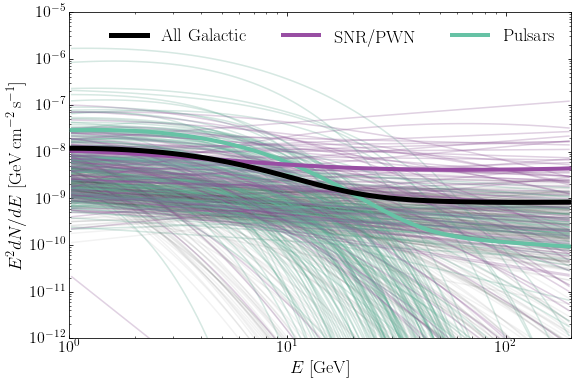

In [7]:
f,ax = plt.subplots(1,figsize=(9,6))
for sp in spec_3fgl:
    ax.loglog(E3fgl_mean,E3fgl_mean**2*sp,alpha=0.05,zorder=1,color='k')

for sp in spec_3fgl_snr:
    ax.loglog(E3fgl_mean,E3fgl_mean**2*sp,alpha=0.2,zorder=3,color=c4)

for sp in spec_3fgl_psr:
    ax.loglog(E3fgl_mean,E3fgl_mean**2*sp,alpha=0.2,zorder=2,color=c1)
    
ax.loglog(E3fgl_mean,E3fgl_mean**2*np.mean(spec_3fgl,axis=0),color='k',alpha=1,lw=5,zorder=10,label='All Galactic')
ax.loglog(E3fgl_mean,E3fgl_mean**2*np.mean(spec_3fgl_snr,axis=0),color=c4,alpha=1,lw=4,zorder=9,label='SNR/PWN')
ax.loglog(E3fgl_mean,E3fgl_mean**2*np.mean(spec_3fgl_psr,axis=0),color=c1,alpha=1,lw=4,zorder=8,label='Pulsars')

ax.set_ylim([1e-12,1e-5])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$",fontsize=18)
ax.set_xlabel(r"$E$ [GeV]",fontsize=18)
ax.set_xlim([1,200])
ax.legend(frameon=False,fontsize=18,loc=1,ncol=3)
# plt.savefig('3fgl_spec.pdf',bbox_inches='tight')

## Load the diffuse pion emission as measured with SkyFACT

In [8]:
def log_interp(zz, xx, yy):
    logz = np.log10(zz)
    logx = np.log10(xx)
    logy = np.log10(yy)
    return np.power(10.0, np.interp(logz, logx, logy))

In [9]:
###Diffuse pion

###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.

import open_dat
from scipy.optimize import curve_fit

##These longitudes and latitude cuts
lb = [(20,180),(5,40)]

modelfunc = lambda x,p1,p2: p1-p2*x
model27 = lambda x,p: p-2.7*x  
plotfunc = lambda E,a,b: b*(E)**-a

def get_diffuse(E):
    spec_diff_lb = []
    spec_diff_lb_27 = []
    ##At different lb
    for ilb in lb:
#         datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_F_spectra_b%s_l%s.dat'%ilb)
        datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_F_spectra_b%s_l%s.dat'%ilb)
        spec,E_diff,error = simulation.read_datfile(datfile)
        mask_E_diff = E_diff > 0
        E_diff = E_diff[mask_E_diff]
        spec = spec[mask_E_diff]
        err = error[mask_E_diff]

        fit,cov = curve_fit(modelfunc,np.log10(E_diff),np.log10(spec),p0=[-7,2.7],sigma=err/spec)
        fitted_spec = plotfunc(Emean,fit[1],10**fit[0]) ##If this is a softer spectra this matters a lot!
        fit27,cov27 = curve_fit(model27,np.log10(E_diff),np.log10(spec),p0=[-7],sigma=err/spec)

        ####This matters a lot!
        diff_index = fit[1]
        fitted_spec = plotfunc(E,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!
        fitted_spec = log_interp(E,E_diff,spec)#np.interp(E,E_diff,spec)
        fitted_spec_27 = plotfunc(E,2.7,10**fit27[0])
        spec_diff_lb.append(fitted_spec)
        spec_diff_lb_27.append(fitted_spec_27)
    return spec_diff_lb,spec_diff_lb_27
    
spec_diff_lb_3fgl,spec_diff_lb_27_3fgl = get_diffuse(E3fgl_mean)

## Function to sample galaxy and calculate things we want to know
Namely: fraction of flux from unresolved sources, latitude,longitude profiles and histogram of flux

In [10]:
R_rings = np.array([(0,1.7),(1.7,4.5),(4.5,5.5),(5.5,6.5),(6.5,7.),(7.,8.),(8.0,10.0),(10.0,16.5),(16.5,50)])

In [13]:
def fraction(N,a,Lmin,Lmax,thres,Eb,spec,spec_diff_lb,bins,spatialmodel='LorimerC'):
    Emean = (Eb[1:]+Eb[0:-1])/2.
    dE = (Eb[1:]-Eb[0:-1])
    spec_sim,flux_sim,lb_sim,R_sim = simulation.source_sim(N,a,Lmin,Lmax,spec,Emean,dE,thres,spatialmodel=spatialmodel)
    l_sim = lb_sim[0,:]
    b_sim = lb_sim[1,:]
    fluxmask = flux_sim < thres
    flux_unres = flux_sim[fluxmask]
    l_unres = l_sim[fluxmask]
    b_unres = b_sim[fluxmask]
#     R_unres = R_sim[fluxmask]
#     print R_sim.shape
    spec_R = []
    for rr in R_rings:
        mask_R = (R_sim >= rr[0])&(R_sim < rr[1])
        totalspec_R = np.sum(spec_sim[fluxmask&mask_R],axis=0)
        spec_R.append(totalspec_R)
        
    frac_lb = []
    spec_lb = []
    unres_spec_sim = spec_sim[fluxmask]
    total_unres_spec = np.sum(unres_spec_sim,axis=0)
    for ilb,_lb in enumerate(lb):
        diff_lb = spec_diff_lb[ilb]
        lmask = l_sim<=_lb[0]
        bmask = b_sim<=_lb[1]
        totalspec = np.sum(spec_sim[fluxmask&bmask&lmask],axis=0)
        frac = totalspec/diff_lb
        frac_lb.append(frac)
        spec_lb.append(totalspec)

    mp = makemap.makemap(l_unres,b_unres,flux_unres,0.5)
    hist = np.histogram(flux_sim,bins=bins)[0]

    return mp,frac_lb,spec_lb,hist,spec_R

## Some more function definitions to use later

In [56]:
def stats(array):
    mean = np.mean(array,axis=0)
    std = np.std(array,axis=0)
    amin = mean-std
    amax = mean+std
    return mean,amin,amax

def rebin(x, nrebin,mean = False, quadratic = False):
    g = 2. if quadratic else 1.
    if mean:
        return ((x**g).reshape(-1, nrebin).mean(axis=1))**(1./g)
    else:
        return ((x**g).reshape(-1, nrebin).sum(axis=1))**(1./g)

    
bcut = 5
bcut2 = 20.25
def ave_sim(n,options):
    """
    Function to sample fraction function n times with options
    Return average of fraction,hist,longitude,latitiude profiles
    """
    nrebin = 10
    lspace = np.linspace(180,-180,720)
    bspace = np.linspace(-90,90,361) #map
    #bcut = 20.25
    maskb = np.abs(bspace)<=bcut
    maskb2 =np.abs(bspace)<=bcut2
    mp_list = []
    frac_list = []
    l_list = []
    b_list = []
    hist_list = []
    mp_list = []
    spec_list = []
    spec_R_list = []
    N,a,Lmin,Lmax,thres = options[:5]
    spat_mod = options[:-1]
    print "Doing %s Galaxy simulations with %s sources with a=%s, Lmin=%s, Lmax=%s, thres=%s"%(n,
                                                                                               N,a,Lmin,Lmax,thres)
    for i in range(n):
        mp,frac_lb,spec,hists,specR = fraction(*options)
        unres_l = np.sum(mp[maskb][:,:],axis=0)
        unres_b = np.sum(mp[maskb2],axis=1)
        mp_list.append(mp)
        frac_list.append(frac_lb)
        l_list.append(rebin(unres_l,nrebin,mean=True))
        b_list.append(unres_b)
        hist_list.append(hists)
        spec_list.append(spec)
        spec_R_list.append(specR)

    l_list = np.array(l_list)
    hist_list = np.array(hist_list)
    hist_stats = stats(hist_list)
    frac_list = np.array(frac_list)
    frac_stats = stats(frac_list)
    l_stats = stats(l_list)
    b_stats = stats(b_list)
    mp_stats = stats(mp_list)
    spec_stats = stats(spec_list)
    spec_R_stats= stats(spec_R_list)
    
    print "...done"
    return (hist_stats,frac_stats,l_stats,b_stats,options),mp_list,spec_stats,spec_R_stats
    
def plot_lb_profile(ops,save=False,fhl=False):
    "Plot lb profiles with output ave_sim"
  
    ###Fraction flux l,b
    nrebin=10
        
    labeling = "1-100"
    ylim = [5e-11,1e-6]
    all_gr = np.loadtxt('all_gr.dat')*7.6e-5
    if fhl:
        all_gr =  np.loadtxt('all_gr_10.dat')*7.6e-5
    lspace_gr = np.linspace(180,-180,720)
#     bcut2 = 20.25
    bspace_gr  = np.linspace(-bcut,bcut,all_gr.shape[0])
    bspace_gr2  = np.linspace(-bcut2,bcut2,all_gr.shape[0])

    lmask = np.abs(lspace_gr)<1e3
    bmask = np.abs(bspace_gr)<=bcut
    bmask2 = np.abs(bspace_gr)<=bcut2

    all_gr_l = np.sum(all_gr[bmask][:,lmask],axis=0)
    all_gr_b = np.sum(all_gr[:,lmask][bmask2,:],axis=1)    
    lspace = rebin(lspace_gr,nrebin,mean=True)
    bspace = bspace_gr2
    all_gr_l = rebin(all_gr_l,nrebin,mean=True)
    mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
    mod =1
    f,(ax2,ax) = plt.subplots(2,figsize=(11,6),sharex=True)

    ax2.plot(lspace,all_gr_l,color=c5,ls=':',label=r'$\pi^0$ diffuse emission')
    for op in ops:
        
        if mod==1:
            lw = 3
        else:
            lw =2 
    
        lmean,lmin,lmax = op[2]
        ax.plot(lspace,lmean/all_gr_l,zorder=10,lw=lw,label='Model %s'%mod)
        ax.fill_between(lspace,lmin/all_gr_l,lmax/all_gr_l,alpha=0.3)
        ax.set_title('Fraction',fontsize=18)
    #     ax2 = ax.twinx()
        ax2.plot(lspace,lmean,ls='--',label='Model %s'%mod,lw=lw)
        ax2.fill_between(lspace,lmin,lmax,alpha=0.3)
       
        ax2.set_yscale('log',nonposy='clip')
#         ax.set_yscale('log',nonposy='clip')
        ax.set_ylim([0,0.3])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}$",fontsize=18)
        ax.set_xlabel(r"$l$ [deg]",fontsize=18)
        ax2.set_ylabel(r"$\rm \Phi\, [ph\,cm^{-2}\,s^{-1}]$",fontsize=18)
        ax.set_xlim([-180,180])
        ax2.set_xlim([-180,180])
        ax.legend(frameon=False,fontsize=16,loc=1,ncol=3)
        ax2.legend(frameon=False,fontsize=16,loc=1,ncol=4)
        ax2.set_ylim([1e-10,1e-7])
        locmaj = matplotlib.ticker.LogLocator(base=10.0, numticks=6)
        ax2.yaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=6)
        ax2.yaxis.set_minor_locator(locmin)
        ax2.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        majorLocator = matplotlib.ticker.FixedLocator([0.0,0.1,0.2,0.3])

        ax.yaxis.set_major_locator(majorLocator)
        locmin = matplotlib.ticker.MultipleLocator(0.02)
        ax.yaxis.set_minor_locator(locmin)

        ax2.set_title(r'Longitude profile $|b|<%s$'%bcut,fontsize=18)
        mod +=1
    if save:
        plt.savefig('profile_l_UPS_pi.pdf',bbox_inches='tight')
    
    f,(ax2,ax) = plt.subplots(2,figsize=(11,6),sharex=True)

    mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
    ax2.plot(bspace,all_gr_b,color=c5,ls=':',label=r'$\pi^0$ diffuse emission')
    mod = 1
    for op in ops:
        bmean,bmin,bmax = op[3]
        
        if mod==1:
            lw=3
        else:
            lw =2 
        
        ax.plot(bspace,bmean/all_gr_b,zorder=10,lw=lw,label='Model %s'%mod)
        ax.set_title('Fraction',fontsize=18)
        ax.fill_between(bspace,bmin/all_gr_b,bmax/all_gr_b,alpha=0.3)
    #     ax2 = ax.twinx()
        ax2.plot(bspace,bmean,ls='--',label='Model %s'%mod,lw=lw)
        ax2.fill_between(bspace,bmin,bmax,alpha=0.3)

        ax2.set_yscale('log',nonposy='clip')
#         ax.set_yscale('log',nonposy='clip')
        ax.set_ylim([0,0.3])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax.set_xlim([-20,20])
        ax2.set_xlim([-20,20])
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}$",fontsize=18)
        ax.set_xlabel(r"$b$ [deg]",fontsize=18)
        ax2.set_ylabel(r"$\rm \Phi\,[ph\,cm^{-2}\,s^{-1}]$",fontsize=18)
        majorLocator = matplotlib.ticker.FixedLocator([0.0,0.1,0.2,0.3])

        ax.yaxis.set_major_locator(majorLocator)
        locmin = matplotlib.ticker.MultipleLocator(0.02)
        ax.yaxis.set_minor_locator(locmin)

        ax.legend(frameon=False,fontsize=16,loc=1,ncol=3)
        ax2.legend(frameon=False,fontsize=16,loc=1,ncol=4)
        ax2.set_title(r'Latitude profile $|l|<180$',fontsize=18)
        ax2.set_ylim([1e-9,1e-4])
        mod+=1
    if save:
        plt.savefig('profile_b_UPS_pi.pdf',bbox_inches='tight')

## Test different spatial dist for SNR and pulsars

In [102]:
op_psr,mp_psr,spec_psr,specR_psr = ave_sim(10,[19000,1.8,2e34,2e39,1e-9,
                                               E3fgl,spec_3fgl_psr,spec_diff_lb_3fgl,bins_3fgl,'LorimerC'])
op_snr,mp_snr,spec_snr,specR_snr = ave_sim(10,[10000,1.8,2e34,1e39,1e-9,
                                               E3fgl,spec_3fgl_snr,spec_diff_lb_3fgl,bins_3fgl,'SNRGreen'])

Doing 10 Galaxy simulations with 19000 sources with a=1.8, Lmin=2e+34, Lmax=2e+39, thres=1e-09
...done
Doing 10 Galaxy simulations with 10000 sources with a=1.8, Lmin=2e+34, Lmax=1e+39, thres=1e-09
...done


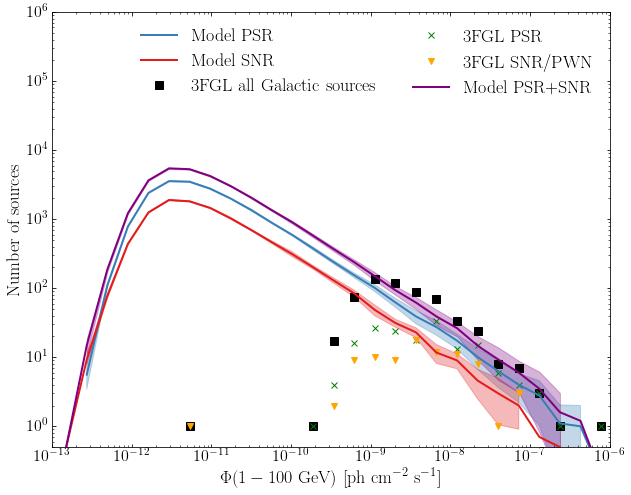

In [98]:
f,ax = plt.subplots(1,figsize=(10,8))
bins_mean = bins_3fgl_mean
# hist_norm = hist_3fgl
model = ['PSR','SNR']
mod = 1
for op in [op_psr,op_snr]:
    hist_mean,hist_min,hist_max = op[0]
    options = op[4]
    hist_min = hist_min.astype('float')
    hist_min[hist_min==0]=1e-5
    N,a,Lmin = options[0:3]
    if N==29000:
        lw=3
    else:
        lw =2 
    line,=ax.loglog(bins_mean,hist_mean,label=r'Model %s'%(model[mod-1]),lw=lw)
    color=line.get_color()
    ax.fill_between(bins_mean,hist_min,hist_max,where=((hist_min >0)&(hist_max>0)),alpha=0.3,color=color)
    mod +=1
    ax.set_yscale('log',nonposy='clip')
    ax.set_xlim([1e-13,1e-6])
    ax.set_ylim([5e-1,1e6])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
    ax.set_ylabel(r"Number of sources",fontsize=18)
    ax.set_xlabel(r"$\Phi(1-100 \ \rm GeV) \ [\rm ph \ cm^{-2}\ s^{-1}]$",fontsize=18)
    
ax.loglog(bins_mean,hist_3fgl,marker='s',label='3FGL all Galactic sources',ls='',ms=8,color='k',zorder=1)
# ax.loglog(bins_mean,hist_3fgl_snr,marker='v',label='3FGL SNR/PWN',ls='',ms=5,color=c1,zorder=1)
# ax.loglog(bins_mean,hist_3fgl_ass,marker='o',label='3FGL identified/associated sources',ls='',ms=6,color=c5,zorder=1)
ax.loglog(bins_mean,hist_3fgl_psr,marker='x',label='3FGL PSR',ls='',ms=6,color='green',zorder=1)
ax.loglog(bins_mean,hist_3fgl_snr,marker='v',label='3FGL SNR/PWN',ls='',ms=6,color='orange',zorder=1)
ax.loglog(bins_mean,op_psr[0][0]+op_snr[0][0],label=r'Model PSR+SNR',lw=lw,color='purple')
hist_min = op_psr[0][1]+op_snr[0][1]
hist_max = op_psr[0][2]+op_snr[0][2]
ax.fill_between(bins_mean,hist_min,hist_max,where=((hist_min >0)&(hist_max>0)),alpha=0.3,color='purple')

ax.legend(frameon=False,loc=1,fontsize=18,ncol=2)
# plt.savefig('hist_3mod.pdf',bbox_inches='tight')

## Do simulations
First: options as from 3FGL paper
Second: lower limit, flatter lum function
3rd: Upper limit, steeper lum function

In [33]:
op1,mp_1,spec1,spec1_R = ave_sim(10,[29000,1.8,2e34,2e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])
op2,mp_2,spec2,spec2_R = ave_sim(10,[3000,1.5,4e34,2e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])
op3,mp_3,spec3,spec3_R = ave_sim(10,[210000,2.1,1e34,2e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])

Doing 10 Galaxy simulations with 29000 sources with a=1.8, Lmin=2e+34, Lmax=2e+39, thres=1e-09
...done
Doing 10 Galaxy simulations with 3000 sources with a=1.5, Lmin=4e+34, Lmax=2e+39, thres=1e-09
...done
Doing 10 Galaxy simulations with 210000 sources with a=2.1, Lmin=1e+34, Lmax=2e+39, thres=1e-09
...done


# Histogram
Compare with resolved sources in 3FGL catalog

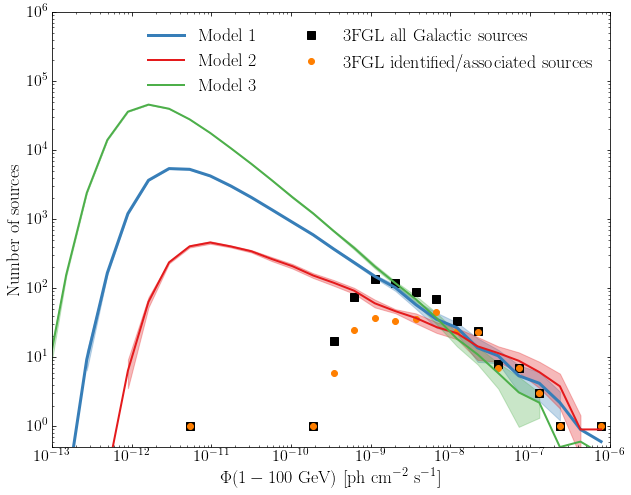

In [63]:
f,ax = plt.subplots(1,figsize=(10,8))
bins_mean = bins_3fgl_mean
hist_norm = hist_3fgl
mod = 1
for op in [op1,op2,op3]:
    hist_mean,hist_min,hist_max = op[0]
    options = op[4]
    hist_min = hist_min.astype('float')
    hist_min[hist_min==0]=1e-5
    N,a,Lmin = options[0:3]
    if N==29000:
        lw=3
    else:
        lw =2 
    line,=ax.loglog(bins_mean,hist_mean,label=r'Model %s'%(mod),lw=lw)
    color=line.get_color()
    ax.fill_between(bins_mean,hist_min,hist_max,where=((hist_min >0)&(hist_max>0)),alpha=0.3,color=color)
    mod +=1
    ax.set_yscale('log',nonposy='clip')
    ax.set_xlim([1e-13,1e-6])
    ax.set_ylim([5e-1,1e6])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
    ax.set_ylabel(r"Number of sources",fontsize=18)
    ax.set_xlabel(r"$\Phi(1-100 \ \rm GeV) \ [\rm ph \ cm^{-2}\ s^{-1}]$",fontsize=18)
    
ax.loglog(bins_mean,hist_norm,marker='s',label='3FGL all Galactic sources',ls='',ms=8,color='k',zorder=1)
# ax.loglog(bins_mean,hist_3fgl_snr,marker='v',label='3FGL SNR/PWN',ls='',ms=5,color=c1,zorder=1)
ax.loglog(bins_mean,hist_3fgl_ass,marker='o',label='3FGL identified/associated sources',ls='',ms=6,color=c5,zorder=1)

ax.legend(frameon=False,loc=1,fontsize=18,ncol=2)
# plt.savefig('hist_3mod.pdf',bbox_inches='tight')

# Profiles

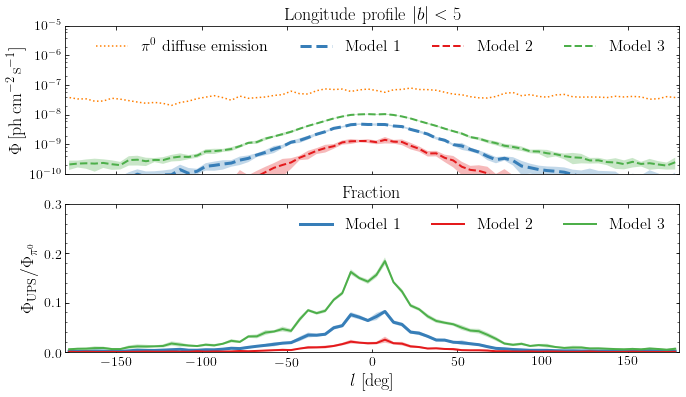

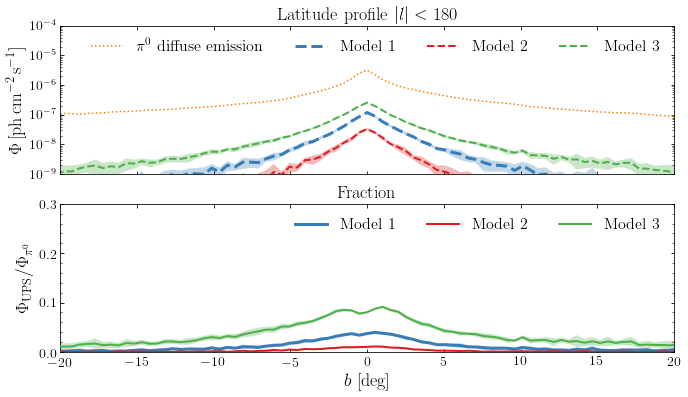

In [64]:
plot_lb_profile([op1,op2,op3],save=False)

# Energy dependence

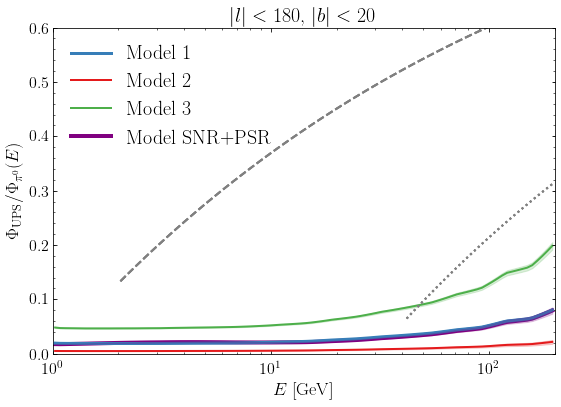

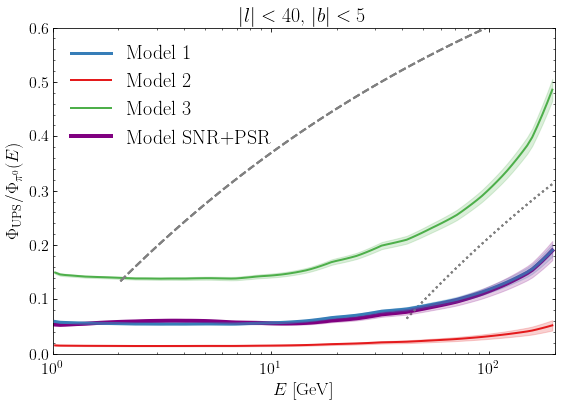

In [103]:
f,ax1 = plt.subplots(1,figsize=(9,6))
f2,ax2= plt.subplots(1,figsize=(9,6))
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
mod = 1
for op in [op1,op2,op3]:
    fracmean,fracmin,fracmax = op[1]
    options = op[4]
    E = options[5]
    Emean = (E[1:]+E[:-1])/2.
    N,a,Lmin = options[:3]
    if N==29000:
        lw = 3
        zorder = 88
    else:
        lw=2
        zorder = 1

    line, = ax1.plot(Emean,fracmean[0],label=r'Model %s'%mod,lw=lw,zorder=zorder)
    c = line.get_color()
    ax1.fill_between(Emean,fracmin[0],fracmax[0],alpha=0.2,color=c,zorder=zorder)
    ax1.set_title(r"$|l| < %s$, $|b|<%s$"%(lb[0][1],lb[0][0]),fontsize=20)
    
    line, = ax2.plot(Emean,fracmean[-1],label=r'Model %s'%mod,color=c,ls='-',lw=lw,zorder=zorder)
    ax2.fill_between(Emean,fracmin[-1],fracmax[-1],alpha=0.2,color=c,zorder=zorder)
    ax2.set_title("$|l| < %s$, $|b|<%s$"%(lb[-1][1],lb[-1][0]),fontsize=20)
    
    ax1.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.2,ls='--',color='grey',lw=2)
    ax1.plot(Emean[Emean>40],1-(Emean[Emean>40]/30.)**-0.2,ls=':',color='grey',lw=2)

    ax2.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.2,ls='--',color='grey',lw=2)
    ax2.plot(Emean[Emean>40],1-(Emean[Emean>40]/30.)**-0.2,ls=':',color='grey',lw=2)



    mod +=1
    for ax in [ax1,ax2]:
        ax.set_xscale('log')
#         ax.set_yscale('log')
        ax.set_ylim([0,0.6])
        ax.set_xlim([1,200])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)

        majorLocator = matplotlib.ticker.FixedLocator([0.0,0.1,0.2,0.3,0.4,0.5,0.6])

        ax.yaxis.set_major_locator(majorLocator)
        locmin = matplotlib.ticker.MultipleLocator(0.02)
        ax.yaxis.set_minor_locator(locmin)
        ax.tick_params(axis='x',pad=10)
   
        
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=18)
        ax.set_xlabel(r"$E$ [GeV]",fontsize=18)

ps_min = op_psr[1][1][0]+op_snr[1][1][0]
ps_max = op_psr[1][2][0]+op_snr[1][2][0]
ax1.plot(Emean,op_psr[1][0][0]+op_snr[1][0][0],label=r'Model SNR+PSR',lw=4,zorder=zorder,color='purple')
ax1.fill_between(Emean,ps_min,ps_max,alpha=0.2,color='purple',zorder=99)

ps_min = op_psr[1][1][1]+op_snr[1][1][1]
ps_max = op_psr[1][2][1]+op_snr[1][2][1]

ax2.plot(Emean,op_psr[1][0][1]+op_snr[1][0][1],label=r'Model SNR+PSR',lw=4,zorder=zorder,color='purple')
ax2.fill_between(Emean,ps_min,ps_max,alpha=0.2,color='purple',zorder=99)

ax1.legend(frameon=False,fontsize=20,loc=2,ncol=1)
ax2.legend(frameon=False,fontsize=20,loc=2,ncol=1)

#         ax.yaxis.set_minor_locator(locmin)
#         ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
f.savefig('UPS_E_plot_all_SNR_PSR_green.pdf',bbox_inches='tight')
f2.savefig('UPS_E_plot_inner_SNR_PSR_green.pdf',bbox_inches='tight')

# 3FHL

In [67]:
E3fhl = np.logspace(1,np.log10(200),101)
E3fhl_mean = (E3fhl[1:]+E3fgl[:-1])/2.
dE_3fhl = (E3fhl[1:]-E3fhl[:-1])/2.
bins_3fhl = np.logspace(-15,-7,32)
bins_3fhl_mean = (bins_3fhl[1:]+bins_3fhl[0:-1])/2.

In [80]:
fl2 = 'gll_psch_v13.fit'
flux_3fhl,spec_3fhl = simulation.read_catalog(fl2,E3fhl_mean,classes=['pwn','spp','snr','psr','lat'])
##'lat' means take also unassociated sources with |b|<5
hist_3fhl = np.histogram(flux_3fhl,bins=bins_3fhl)[0]

In [81]:
spec_diff_lb_3fhl,spec_diff_lb_3fhl_27 = get_diffuse(E3fhl_mean)

In [82]:
### Change Lmin and Lmax for 3FHL, 
##should actually adjust the models to give better fit to high flux sources from 3FHL


op1,mp_1,spec1,spec1_R = ave_sim(10,[29000,1.8,2e33,1e37,1e-10,E3fhl,spec_3fhl,spec_diff_lb_3fhl,bins_3fhl])
op2,mp_2,spec2,spec2_R = ave_sim(10,[3000,1.5,4e33,1e37,1e-10,E3fhl,spec_3fhl,spec_diff_lb_3fhl,bins_3fhl])
op3,mp_3,spec3,spec3_R = ave_sim(10,[210000,2.1,1e33,1e37,1e-10,E3fhl,spec_3fhl,spec_diff_lb_3fhl,bins_3fhl])

Doing 10 Galaxy simulations with 29000 sources with a=1.8, Lmin=2e+33, Lmax=1e+37, thres=1e-10
...done
Doing 10 Galaxy simulations with 3000 sources with a=1.5, Lmin=4e+33, Lmax=1e+37, thres=1e-10
...done
Doing 10 Galaxy simulations with 210000 sources with a=2.1, Lmin=1e+33, Lmax=1e+37, thres=1e-10
...done


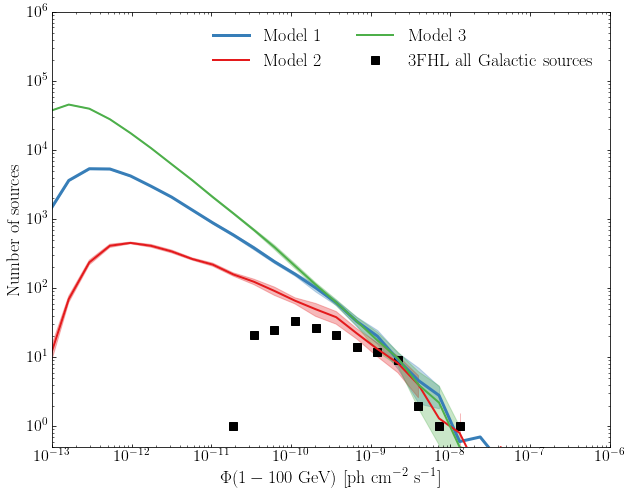

In [84]:
f,ax = plt.subplots(1,figsize=(10,8))
bins_mean = bins_3fhl_mean
hist_norm = hist_3fhl
mod = 1
for op in [op1,op2,op3]:
    hist_mean,hist_min,hist_max = op[0]
    options = op[4]
    hist_min = hist_min.astype('float')
    hist_min[hist_min==0]=1e-5
    N,a,Lmin = options[0:3]
    if N==29000:
        lw=3
    else:
        lw =2 
    line,=ax.loglog(bins_mean,hist_mean,label=r'Model %s'%(mod),lw=lw)
    color=line.get_color()
    ax.fill_between(bins_mean,hist_min,hist_max,where=((hist_min >0)&(hist_max>0)),alpha=0.3,color=color)
    mod +=1
    ax.set_yscale('log',nonposy='clip')
    ax.set_xlim([1e-13,1e-6])
    ax.set_ylim([5e-1,1e6])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
    ax.set_ylabel(r"Number of sources",fontsize=18)
    ax.set_xlabel(r"$\Phi(1-100 \ \rm GeV) \ [\rm ph \ cm^{-2}\ s^{-1}]$",fontsize=18)
    
ax.loglog(bins_mean,hist_norm,marker='s',label='3FHL all Galactic sources',ls='',ms=8,color='k',zorder=1)
# ax.loglog(bins_mean,hist_3fgl_snr,marker='v',label='3FGL SNR/PWN',ls='',ms=5,color=c1,zorder=1)
# ax.loglog(bins_mean,hist_3fgl_ass,marker='o',label='3FHL identified/associated sources',ls='',ms=6,color=c5,zorder=1)

ax.legend(frameon=False,loc=1,fontsize=18,ncol=2)
# plt.savefig('hist_3mod.pdf',bbox_inches='tight')

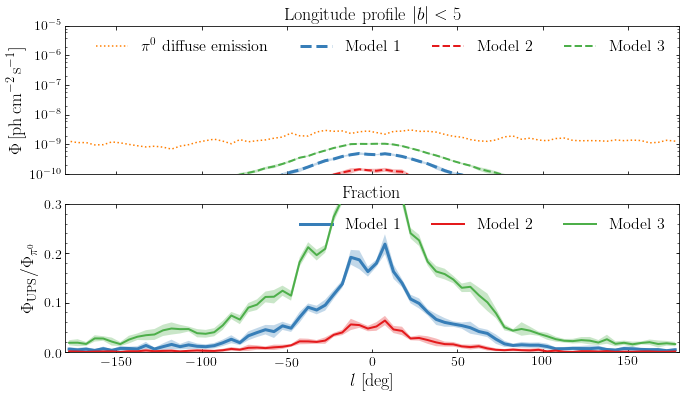

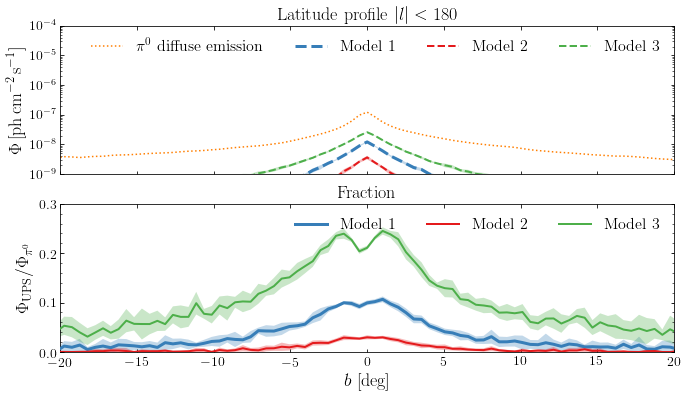

In [85]:
plot_lb_profile([op1,op2,op3],fhl=True)


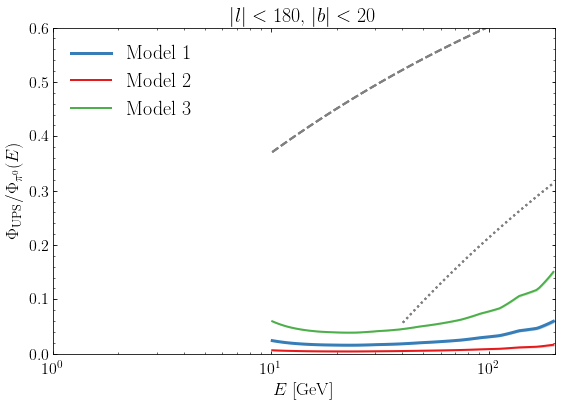

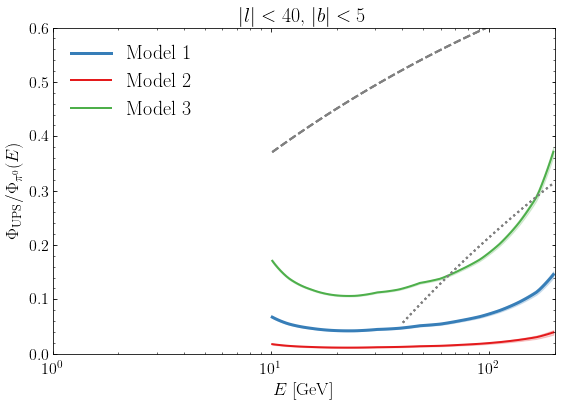

In [86]:
f,ax1 = plt.subplots(1,figsize=(9,6))
f2,ax2= plt.subplots(1,figsize=(9,6))
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
mod = 1
for op in [op1,op2,op3]:
    fracmean,fracmin,fracmax = op[1]
    options = op[4]
    E = options[5]
    Emean = (E[1:]+E[:-1])/2.
    N,a,Lmin = options[:3]
    if N==29000:
        lw = 3
        zorder = 88
    else:
        lw=2
        zorder = 1

    line, = ax1.plot(Emean,fracmean[0],label=r'Model %s'%mod,lw=lw,zorder=zorder)
    c = line.get_color()
    ax1.fill_between(Emean,fracmin[0],fracmax[0],alpha=0.2,color=c,zorder=zorder)
    ax1.set_title(r"$|l| < %s$, $|b|<%s$"%(lb[0][1],lb[0][0]),fontsize=20)
    
    line, = ax2.plot(Emean,fracmean[-1],label=r'Model %s'%mod,color=c,ls='-',lw=lw,zorder=zorder)
    ax2.fill_between(Emean,fracmin[-1],fracmax[-1],alpha=0.2,color=c,zorder=zorder)
    ax2.set_title("$|l| < %s$, $|b|<%s$"%(lb[-1][1],lb[-1][0]),fontsize=20)
    
    ax1.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.2,ls='--',color='grey',lw=2)
    ax1.plot(Emean[Emean>40],1-(Emean[Emean>40]/30.)**-0.2,ls=':',color='grey',lw=2)

    ax2.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.2,ls='--',color='grey',lw=2)
    ax2.plot(Emean[Emean>40],1-(Emean[Emean>40]/30.)**-0.2,ls=':',color='grey',lw=2)

    ax1.legend(frameon=False,fontsize=20,loc=2,ncol=1)
    ax2.legend(frameon=False,fontsize=20,loc=2,ncol=1)

    mod +=1
    for ax in [ax1,ax2]:
        ax.set_xscale('log')
#         ax.set_yscale('log')
        ax.set_ylim([0,0.6])
        ax.set_xlim([1,200])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)

        majorLocator = matplotlib.ticker.FixedLocator([0.0,0.1,0.2,0.3,0.4,0.5,0.6])

        ax.yaxis.set_major_locator(majorLocator)
        locmin = matplotlib.ticker.MultipleLocator(0.02)
        ax.yaxis.set_minor_locator(locmin)
        ax.tick_params(axis='x',pad=10)
   
        
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=18)
        ax.set_xlabel(r"$E$ [GeV]",fontsize=18)
        

#         ax.yaxis.set_minor_locator(locmin)
#         ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
# f.savefig('UPS_E_plot_all.pdf',bbox_inches='tight')
# f2.savefig('UPS_E_plot_inner.pdf',bbox_inches='tight')